In [9]:
import numpy as np
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
from matplotlib import colors
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

In [10]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [11]:
def get_varbs(dirname, fname, time_ind):
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files')
    
    y, x = slice(1,-1,None), slice(1,-1,None)
    
    time_f = time_ind+12 
    # only applied for w-velocity since others are not used in notebook
    # this is just a workaround to get mean w-velocity for 24-36 hours when CTW model vs Mackenzie model match
    # refer to second figure, specifically dispersion curve
    print(time_ind, time_f)
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx0 = np.nanmean(dsU.variables['vozocrtx'][time_ind:time_f,:,y,x], axis=0)
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][time_ind,:,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind,:,y,x]
        print('W')
        vosaline0 = dsT.variables['vosaline'][time_ind,:,y,x]
        votemper0 = dsT.variables['vosaline'][time_ind,:,y,x]
        print('T')
        depthw = dsW.variables['depthw'][:]
        
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask = dsM.variables['umask'][0,:,y,x]
        vmask = dsM.variables['vmask'][0,:,y,x]
        tmask = dsM.variables['tmask'][0,:,y,x]
        fmask = dsM.variables['fmask'][0,:,y,x]
        e2t0 = dsM.variables['e2t'][0, y, x]
        e1t0 = dsM.variables['e1t'][0, y, x]
    
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    
    e2t = np.cumsum(np.nanmean(e2t0, axis=1)) / 1000 # km
    e1t = np.cumsum(np.nanmean(e1t0, axis=0)) / 1000 # km
    
    
    print('w0 shape, tmask shape', vovecrtz0.shape, tmask.shape)
    print('e2, e1', e2t.shape, e1t.shape)
    
    idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
    ideal = idealf['Bathymetry'][y,x]
    
    return vozocrtx, vomecrty, vovecrtz, vosaline, votemper, tmask, depthw, e1t, e2t, ideal

In [12]:
def plot_dispersion(ax, disp_k, disp_f, fs_numb, fs_str):
    ax.plot(disp_k, disp_f, c='k', lw=3, zorder=1)
    ax.set_xlim(0, 4e-6)
    #ax.scatter(k, f, s=350, c='#8B008B', zorder=2, marker='o')
    
    ax.set_xlabel('Wavenumber [rad cm$^{-1}$]', fontsize=fs_str)
    ax.set_ylabel('Frequency [rad s$^{-1}$]', fontsize=fs_str)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.get_offset_text().set_fontsize(fs_numb)
    ax.xaxis.get_offset_text().set_fontsize(fs_numb)
    return ax

In [13]:
# dispersion curve
output = np.loadtxt('/ocean/imachuca/CTW_Brink/output/dispc_J.dat')
disp_k = output[:, 0] #rad/cm
disp_f = output[:, 1] #rad/sec

# Brink mode
file = sio.loadmat('/ocean/imachuca/CTW_Brink/output/figures_J1.mat')
z, xpl, xxx, zzz = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:]
k, f = file['wavenumber'][0][0], file['frequency'][0][0]
p, u, v, w, r = file['p_profile'], file['u_profile'], file['v_profile'], file['w_profile'], file['r_profile']
R = file['ratio_for_wave'][0][0]

# Mackenzie wave
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = 'MCKNZ_1h_20170101_201701*'
meshmaskname = 'mesh_mask.nc'
x_ind = 161
time_ind = 24
vozocrtx, vomecrty, vovecrtz, vosaline, votemper, tmask, depthw, e1t, e2t, ideal = get_varbs(dirname, fname, time_ind)

vovecrtz_plan = np.nanmean(vovecrtz, axis=0) * 100 # cms-1
vovecrtz_cross = vovecrtz[:, :, x_ind] * 100 # cms-1
tmask_cross = tmask[:, :, x_ind]

files
24 36
U
V
W
T
w0 shape, tmask shape (80, 172, 268) (80, 172, 268)
e2, e1 (172,) (268,)


Mackenzie Wave:
wavelength [m] 81000 wavenumber [rad/cm] 7.757018897752575e-07

CTW wave:
wavenumber [rad/cm] 7.757e-07 frequency [rad s$^{-1}$] 6.0072751953124994e-05


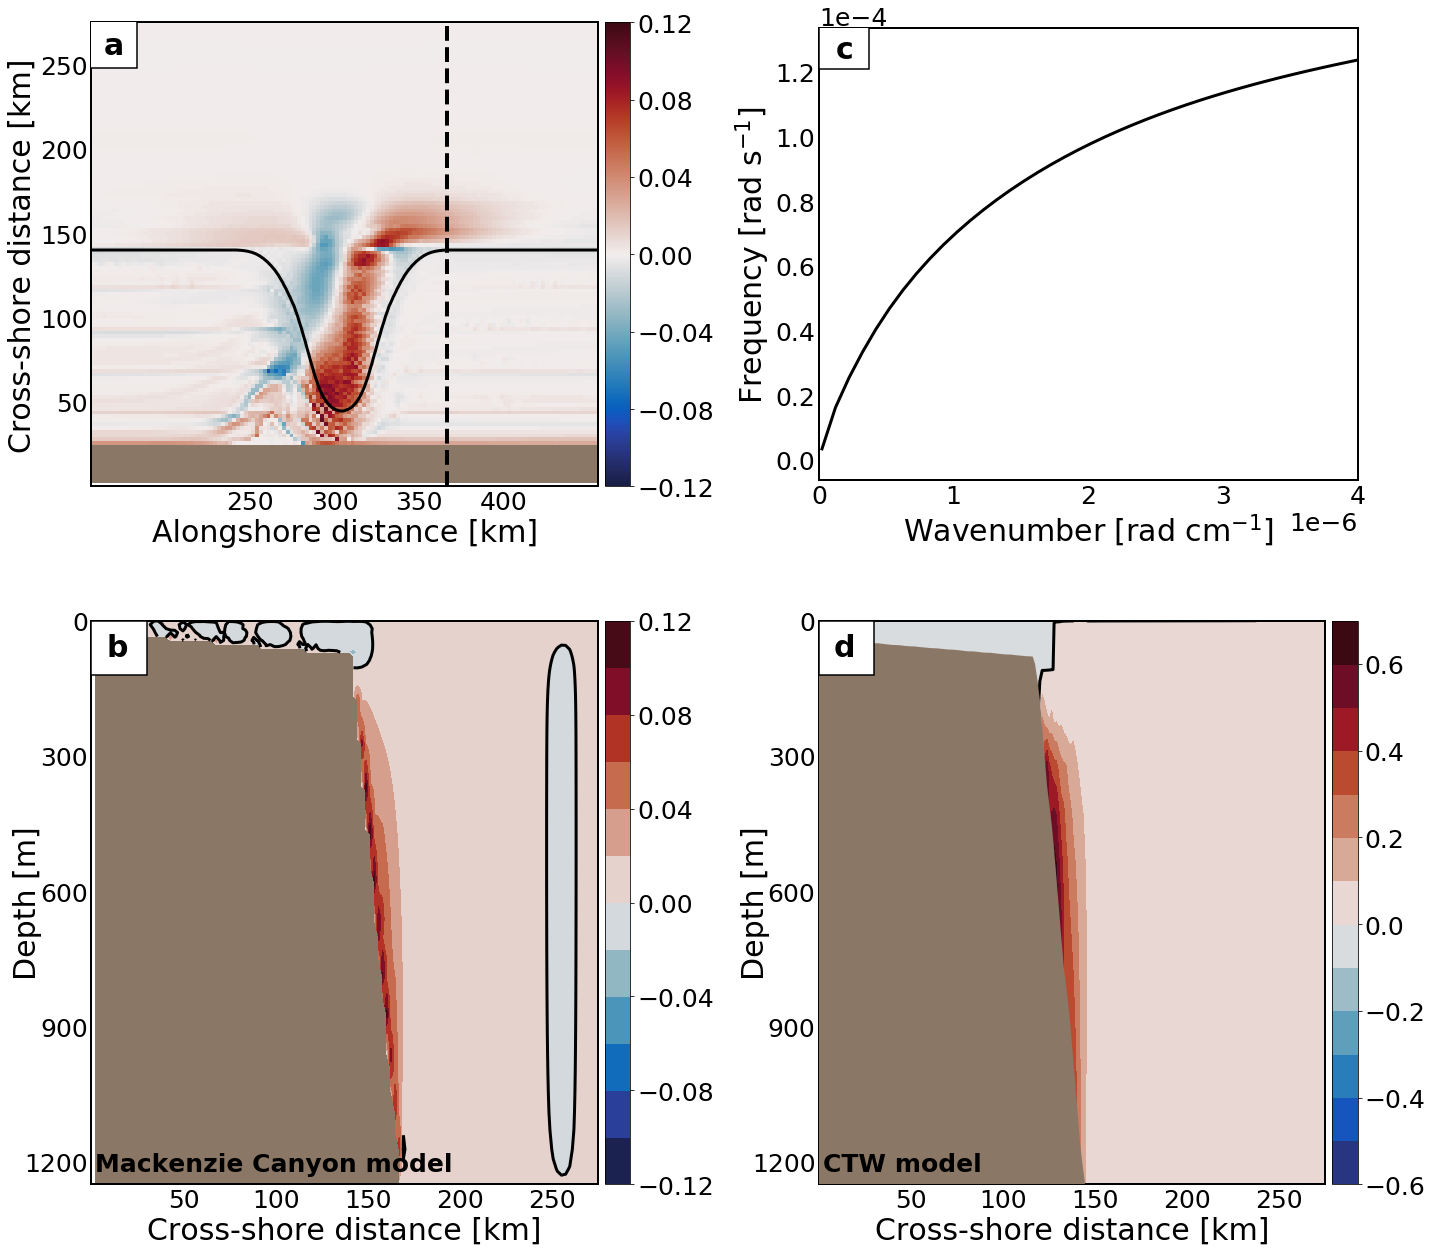

In [14]:
# figure
kind='ideal'
landc = '#8b7765'
fs_numb, fs_str = 25, 30
cmap = cmo.cm.balance
cmap.set_bad(landc)
norm = MidpointNormalize(midpoint=0)

if kind == 'ideal':
    x_left, y_bottom = 205.822543591543,24.85159075988878
    mid = 306
    ticklabs = np.arange(250,450,50)
elif kind == 'real':
    x_left, y_bottom = 296.29431501679437, 24.85159075988878
    mid = 400
    ticklabs = np.arange(350,550,50)
        
min_x, max_x = mid-150, mid+150

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])

vm = np.max([abs(np.nanmin(vovecrtz_cross)), abs(np.nanmax(vovecrtz_cross))])
ticks = np.arange(-0.12, 0.13, 0.04) #ax0 vmin,vmax & ax1 levels

# plan view
y_wave = 70
wlength_0_km=260
wlength_f_km=341
p0 = ax0.pcolormesh(e1t, e2t, vovecrtz_plan, vmin=ticks[0], vmax=-ticks[0], cmap=cmo.cm.balance)
ax0.contour(e1t, e2t, ideal, levels=[80], linewidths=3, colors='k')
ax0.axvline(e1t[x_ind], lw=4, linestyle='--', c='k')
ax0.set_xlim([min_x, max_x])
ax0.yaxis.set_ticks(np.arange(50, 300, 50))
ax0.xaxis.set_ticks(ticklabs)
ax0.set_aspect(aspect='equal')
ax0.add_patch(patches.Rectangle((150, 248), (33), (43), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
ax0.annotate('a', xy=(169,261), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
wavelength_m = (wlength_f_km-wlength_0_km)*1000
wavenumber_radcm = (2*np.pi)/(wavelength_m*100)
print('Mackenzie Wave:')
print('wavelength [m]', wavelength_m, 'wavenumber [rad/cm]', wavenumber_radcm)

# Mackenzie wave
colorsList = [landc, 'w']
CustomCmap = matplotlib.colors.ListedColormap(colorsList)
interval = (ticks[1]-ticks[0])*0.5
levels = np.arange(ticks[0], ticks[-1]+interval, interval)
p1 = ax1.contourf(e2t, depthw, vovecrtz_cross, levels=levels, cmap=cmap, vmin=-1*vm, vmax=vm, zorder=2)
ax1.contour(e2t, depthw, vovecrtz_cross, levels=[0], linewidths=3, linestyles='-', colors='k', zorder=3)
ax1.pcolormesh(e2t, depthw, tmask_cross[1:,:], cmap = CustomCmap, zorder=1)
ax1.yaxis.set_ticks(np.arange(0, 1300, 300))
ax1.xaxis.set_ticks(np.arange(50, 300, 50))
ax1.add_patch(patches.Rectangle((0, 0), (30), (120), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
ax1.annotate('b', xy=(14,60), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
ax1.annotate('Mackenzie Canyon model', xy=(2, 1220), fontsize=fs_numb, weight='bold', color='k')

# dispersion curve
ax2 = plot_dispersion(ax2, disp_k, disp_f, fs_numb, fs_str)
ax2.add_patch(patches.Rectangle((0, 1.21e-4), (0.37e-6), (0.2e-4), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
ax2.annotate('c', xy=(0.19e-6,1.27e-4), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
ax2.set_aspect(0.024)
print('\nCTW wave:')
print('wavenumber [rad/cm]', k, 'frequency [rad s$^{-1}$]', f)

# Brink mode
vm = np.max([abs(np.nanmin(w)), abs(np.nanmax(w))])
ticksB = np.arange(-0.6, 0.8, 0.2)
interval = (ticksB[1]-ticksB[0])*0.5
levels = np.arange(ticksB[0], ticksB[-1]+interval, interval)
p3 = ax3.contourf(xpl, z, w, levels=levels, cmap=cmap, vmin=-1*vm, vmax=vm, zorder=1)
ax3.contour(xpl, z, w, levels=[0], linewidths=3, linestyles='-', colors='k', zorder=2)
ax3.fill_between(xxx, zzz.min(), zzz, facecolor=landc, zorder=3)
ax3.yaxis.set_ticks(np.arange(0, -1300, -300))
ax3.xaxis.set_ticks(np.arange(50, 300, 50))
ax3.set_yticklabels([str(int(abs(x))) for x in ax3.get_yticks()])
ax3.add_patch(patches.Rectangle((0, 0), (30), (-120), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
ax3.annotate('d', xy=(14,-60), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
ax3.annotate('CTW model', xy=(2, -1220), fontsize=fs_numb, weight='bold', color='k')

for ax, o, ti in zip([ax0, ax1, ax3], [p0, p1, p3], [ticks, ticks, ticksB]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(o, cax=cax, orientation='vertical', ticks=ti)
    cbar.ax.tick_params(labelsize=fs_numb)
    cbar.ax.get_yaxis().labelpad = 50

for ax in (ax0, ax1, ax2, ax3):
    ax.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        
ymax=275
ax0.set_ylim([0, ymax])
for ax in (ax1, ax3):
    ax.set_xlim([0, ymax])
    ax.set_xlabel('Cross-shore distance [km]', fontsize=fs_str)
    ax.set_ylabel('Depth [m]', fontsize=fs_str, labelpad=-18)

zmax=1250
ax1.set_ylim([zmax, 0])
ax3.set_ylim([-zmax, 0])

ax0.set_xlabel('Alongshore distance [km]', fontsize=fs_str)
ax0.set_ylabel('Cross-shore distance [km]', fontsize=fs_str)

fig.patch.set_facecolor('white')
fig.tight_layout()
plt.subplots_adjust(top=0.99, wspace=0.35, hspace=0.15)

fig.savefig('./fig_wavemode_section.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

w-velocity [cm s$^{-1}$] 0.6459140945953986 [-6.00000000e-01 -4.00000000e-01 -2.00000000e-01  1.11022302e-16
  2.00000000e-01  4.00000000e-01  6.00000000e-01]
u-velocity [cm s$^{-1}$] 26.537098474893487 [-30 -20 -10   0  10  20  30]
pressure [dyne cm$^{-2}$] 4159.686286395229 [-4500 -3000 -1500     0  1500  3000  4500]
v-velocity [cm s$^{-1}$] 51.82567235905961 [-45 -30 -15   0  15  30  45]
density [gm cm$^{-3}$] 0.0014694172935894455 [-0.0015 -0.001  -0.0005  0.      0.0005  0.001   0.0015]


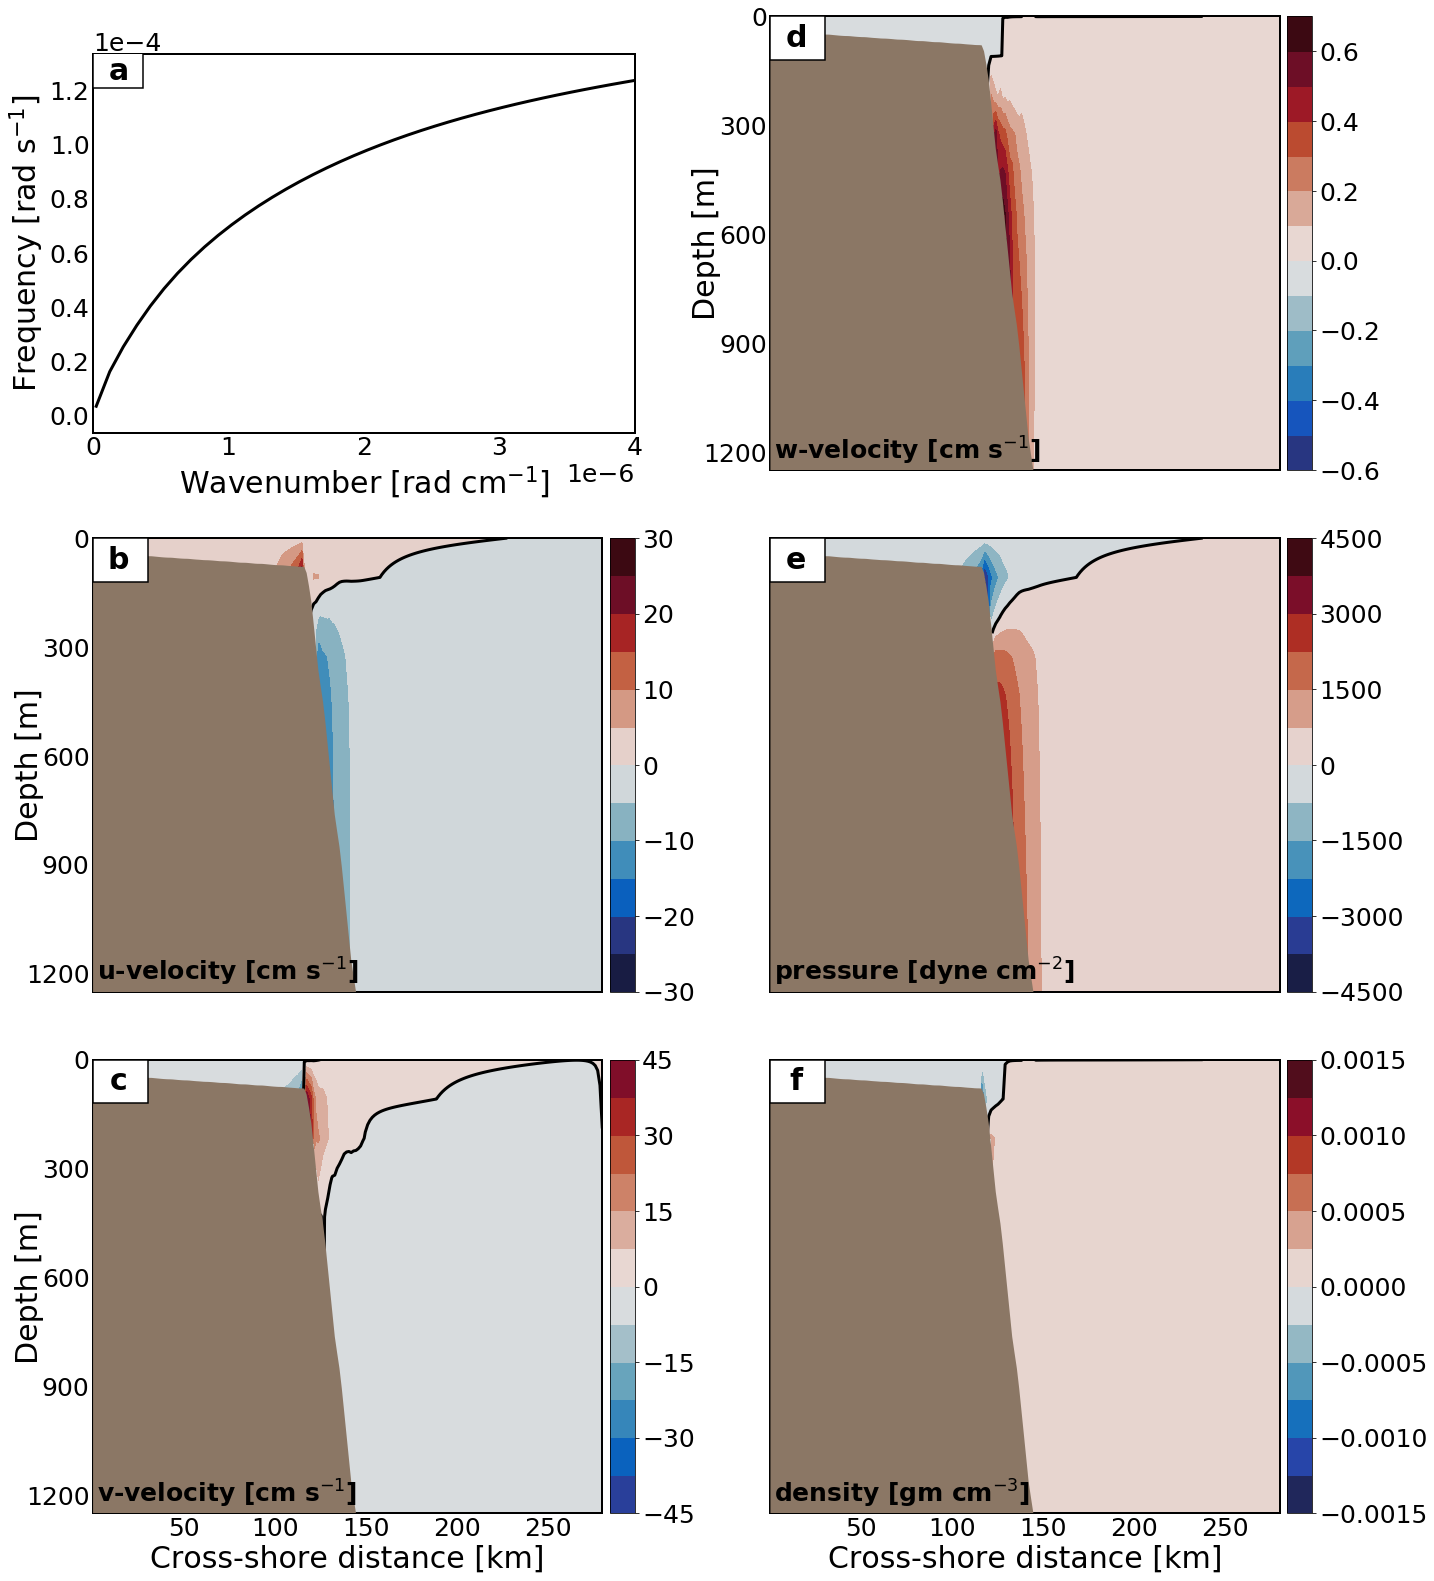

In [15]:
# figure
kind='ideal'
landc = '#8b7765'
fs_numb, fs_str = 25, 30
cmap = cmo.cm.balance
cmap.set_bad(landc)
norm = MidpointNormalize(midpoint=0)

fig = plt.figure(figsize=(20, 22))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1,1])

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

axes = [ax1, ax2, ax3, ax4, ax5]

for ax in ([ax0, ax1, ax2, ax3, ax4, ax5]):
    ax.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        
for ax in ([ax1, ax2, ax3]):
    ax.xaxis.set_tick_params(labelbottom=False)
for ax in ([ax3, ax5]):
    ax.yaxis.set_tick_params(labelbottom=False)
    
for ax in ([ax1, ax2, ax4]):
    ax.set_ylabel('Depth [m]', fontsize=fs_str, labelpad=-18)
    
for ax in ([ax4, ax5]):
    ax.set_xlabel('Cross-shore distance [km]', fontsize=fs_str)

arrays = [w, u, p, v, r]
ttls = ['w-velocity [cm s$^{-1}$]', 'u-velocity [cm s$^{-1}$]', 'pressure [dyne cm$^{-2}$]', 'v-velocity [cm s$^{-1}$]', 'density [gm cm$^{-3}$]']
tick_all = [np.arange(-0.6, 0.8, 0.2), np.arange(-30, 31, 10), np.arange(-4500, 6000, 1500), np.arange(-45, 46, 15), np.arange(-0.0015, 0.002, 0.0005)]
labs = ['d','b','e','c','f']

cmap = cmo.cm.balance
cmap.set_bad(landc)
norm = MidpointNormalize(midpoint=0)

for ax, array, ttl, lab, tick in zip(axes, arrays, ttls, labs, tick_all):
    
    vm = np.max([abs(np.nanmin(array)), abs(np.nanmax(array))])
    interval = (tick[1]-tick[0])*0.5
    levels = np.arange(tick[0], tick[-1]+interval, interval)
    print(ttl, vm, tick)
    cf = ax.contourf(xpl, z, array, levels=levels, cmap=cmap, vmin=-1*vm, vmax=vm, zorder=1)
    ax.contour(xpl, z, array, levels=[0], linewidths=3, linestyles='-', colors='k', zorder=2)
    
    ax.fill_between(xxx, zzz.min(), zzz, facecolor=landc, zorder=3)
    ax.yaxis.set_ticks(np.arange(0, -1300, -300))
    ax.xaxis.set_ticks(np.arange(50, 300, 50))
    ax.set_yticklabels([str(int(abs(x))) for x in ax.get_yticks()])
    ax.add_patch(patches.Rectangle((0, 0), (30), (-120), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
    ax.annotate(lab, xy=(14,-60), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
    ax.annotate(ttl, xy=(2, -1220), fontsize=fs_numb, weight='bold', color='k')
    zmax=1250; ax.set_ylim([-zmax, 0])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(cf, cax=cax, orientation='vertical', ticks=tick)
    cbar.ax.tick_params(labelsize=fs_numb)
    cbar.ax.get_yaxis().labelpad = 50
    
ax0 = plot_dispersion(ax0, disp_k, disp_f, fs_numb, fs_str)
ax0.add_patch(patches.Rectangle((0, 1.21e-4), (0.37e-6), (0.2e-4), fc='w', ec='k', lw=1.5, alpha=1, zorder=4))
ax0.annotate('a', xy=(0.19e-6,1.27e-4), fontsize=30, weight='bold', va='center', ha='center', zorder=5)
ax0.set_aspect(0.02)
    
fig.patch.set_facecolor('white')
fig.tight_layout()
plt.subplots_adjust(top=0.99, wspace=0.25, hspace=0.15)

fig.savefig('./fig_wavemode_CTW.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

Mackenzie Wave:
wavelength [m] 81000 wavenumber [rad/cm] 7.757018897752575e-07
frequency [rad/s] 6.094689747964199e-05  for hours  24 - 36
frequency [rad/s] 2.261946710584651e-05  for hours  36 - 60

so, CTW mode J1 is the same as the Mackenzie wave with wavelength at hour 24 and frequency between hours 24 - 36


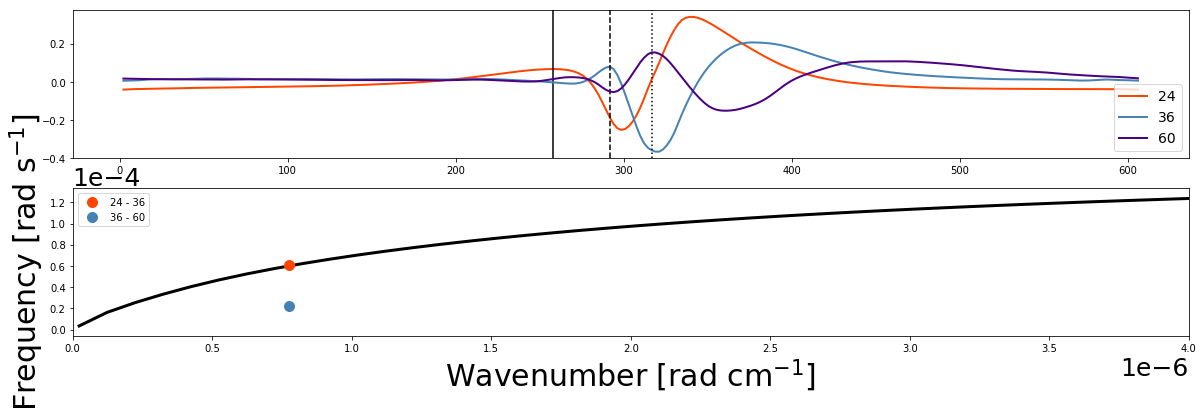

In [16]:
def get_w(dirname, fname, meshmaskname, y_wave, t):
    files = general_functions.get_files(dirname, fname, 'grid_W')        
    y,x = slice(1,-1,None), slice(1,-1,None)
    with scDataset(files) as ds:
        vel0 = ds.variables['vovecrtz'][t,:,y_wave,x]
    vel = np.nanmean(vel0, axis=0)*1000
    return vel

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,6))
# p0 = ax0.pcolormesh(e1t, e2t, vovecrtz_plan, vmin=ticks[0], vmax=-ticks[0], cmap=cmo.cm.balance)
# ax0.set_title('depth averaged at hour '+str(time_ind))
# ax0.axhline(e2t[y_wave],c='k')
    
ts = [24, 36, 60]
mid_inds = [140, 145, 145]
cs = ['orangered', 'steelblue', 'indigo']
xs = []
for t, c, ls, mid_ind in zip(ts, cs, ['-', '--', ':'], mid_inds):
    w = get_w(dirname, fname, meshmaskname, y_wave, t)
    ax1.plot(e1t, w, c=c, label=str(t), lw=2)
    ax1.legend(loc=4, fontsize=14)
    max_ind = np.where(w==w[:mid_ind].max())[0][0]
    this_x = e1t[max_ind]
    ax1.axvline(this_x, c='k', ls=ls)
    xs.append(this_x)

print('Mackenzie Wave:')
print('wavelength [m]', wavelength_m, 'wavenumber [rad/cm]', wavenumber_radcm)

ax2 = plot_dispersion(ax2, disp_k, disp_f, fs_numb, fs_str)

for n in range(2):
    speed = ((xs[n+1]-xs[n])*1000)/((ts[n+1]-ts[n])*60*60) #m/s
    freq_check = 2*np.pi*np.round(speed/wavelength_m,7)
    print('frequency [rad/s]', freq_check, ' for hours ', str(ts[n])+' - '+str(ts[n+1]))
    ax2.scatter(wavenumber_radcm, freq_check, s=100, marker='o', c=cs[n],
                label=str(ts[n])+' - '+str(ts[n+1]), zorder=9)
ax2.legend()
n=0
print('\nso, CTW mode J1 is the same as the Mackenzie wave with wavelength at hour', time_ind, 
      'and frequency between hours', str(ts[n])+' - '+str(ts[n+1]))